In [1]:
import torch
from tqdm import tqdm

from ppo import PPO
from utils import logprobs_from_logits

In [2]:
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer
from gpt2withvaluehead import GPT2HeadWithValueModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentiment_model = AutoModelForSequenceClassification.from_pretrained("distilgpt2").to(device)
gpt2_model = GPT2HeadWithValueModel.from_pretrained("distilgpt2").to(device)
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained("distilgpt2").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")


sentiment_model.config.pad_token_id = tokenizer.eos_token_id
gpt2_model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


#import wandb
#wandb.init(project='transformer_ppo')

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def query_model(query, batch_size, response_len = 32):    
    response_tensors = []
    tensor_shape = query['input_ids'].size(0)
    for i in range(int(tensor_shape/batch_size)):
        with torch.no_grad():
            generation_output = gpt2_model.generate(input_ids=query['input_ids'][i*batch_size:(i+1)*batch_size],
                                                    attention_mask=query['attention_mask'][i*batch_size:(i+1)*batch_size],
                                                    max_length=query['attention_mask'].size(1)+response_len, 
                                                    do_sample=True, 
                                                    top_p = 1.0,)
        for tensor in generation_output:
            response_tensors.append(tensor)
    
    torch.cuda.empty_cache()
    #return tokenizer.pad(response_tensors)
    return tokenizer.pad({'input_ids': response_tensors}, 
                         padding=True)['input_ids'].to(device)


def calculate_scores(combined, batch_size):
    scores_tensor = []
    for i in range(int(combined.size(0)/batch_size)):
        with torch.no_grad():
            
            scores = torch.squeeze(sentiment_model(input_ids = combined[i*batch_size:(i+1)*batch_size])['logits'], dim=1)
        scores_tensor.append(scores)
        
    torch.cuda.empty_cache()
    return torch.cat(scores_tensor)

def get_probs(combined, batch_size, response_len = 32):
    
    values_tensor, logprobs_tensor, ref_logprobs_tensor = [], [], []
    for i in range(int(combined.size(0)/batch_size)):
        
        response = combined[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            outputs = gpt2_model(input_ids = response)
            ref_outputs = gpt2_model_ref(input_ids = response)

        # Not ideal to re-run this but afaik you can't get logits from model.generate
        logprobs = logprobs_from_logits(outputs['logits'][:,:-1,:], 
                                        response[:,1:])[:, -response_len:]
        
        ref_logprobs = logprobs_from_logits(ref_outputs['logits'][:,:-1,:], 
                                            response[:,1:])[:, -response_len:]

        values = torch.squeeze(outputs['values'], dim=2)[:, -response_len-1:-1]
        
        logprobs_tensor.append(logprobs)
        ref_logprobs_tensor.append(ref_logprobs)
        values_tensor.append(values)
        
    return (torch.cat(values_tensor), 
            torch.cat(logprobs_tensor), 
            torch.cat(ref_logprobs_tensor))

def compute_rewards(scores, logprobs, ref_logprobs):
    """Compute per token rewards from scores and KL-penalty."""
    kl = logprobs - ref_logprobs
    non_score_reward = -0.1 * kl
    rewards = non_score_reward.clone().detach()
    rewards[:, -1] += scores
    return rewards

In [4]:
from datasets import load_dataset
datasets = load_dataset("json", field='data', data_files={
    "train": "../data/tldr-filtered-test.json",
    "validation": "../data/tldr-filtered-test.json"
})

# prep dataset
def tokenize_function(examples):
    output = tokenizer(examples['content'], max_length=256, truncation=True, padding=True)
    return output

tokenized_datasets = datasets.map(
    tokenize_function,
    batched=True,
    num_proc=1,
    remove_columns = datasets["train"].column_names
)

from torch.utils.data import DataLoader

batch_size=512
per_device_batch_size=4

def collate_wrapper(batch):
    return tokenizer.pad(batch, return_tensors='pt')
    
loader = DataLoader(tokenized_datasets['train'], batch_size=batch_size, pin_memory=False, collate_fn=collate_wrapper)

Using custom data configuration default
Reusing dataset json (/home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514)
Loading cached processed dataset at /home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-8a0405a96bf7a40c.arrow
Loading cached processed dataset at /home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-c58f4c71967d723a.arrow


In [10]:
optimizer = torch.optim.Adam(gpt2_model.parameters(), lr=1e-5)
ppo = PPO(model=gpt2_model, 
          tokenizer=tokenizer, 
          optimizer=optimizer)
          #wandb = wandb)
r = []
    
for batch in tqdm(loader):
    batch = batch.to(device)
    batch['input_ids'].shape
    
    response_tensors = []
    
    response = query_model(batch, 
                           batch_size=per_device_batch_size)
    
    scores = calculate_scores(response, 
                              batch_size=per_device_batch_size)
    
    values, logprobs, ref_logprobs = get_probs(response, 
                                               batch_size=per_device_batch_size)

    rewards = compute_rewards(scores, logprobs, ref_logprobs)
    
    ppo.step(logprobs, values, rewards, response, per_device_batch_size)
    r.append(rewards.mean())
    
    #wandb.log({
    #    "reward": rewards,
    #    "scores": scores
    #})


  5%|▌         | 4/79 [05:04<1:35:05, 76.07s/it]


KeyboardInterrupt: 

In [ ]:
model_outputs = self.model(model_input)
logits = model_outputs['logits']
vpred = model_outputs['values']

In [6]:
response.shape

torch.Size([512, 288])

In [7]:
    scores = calculate_scores(response, 
                              batch_size=per_device_batch_size)

In [9]:
scores.shape

torch.Size([512])

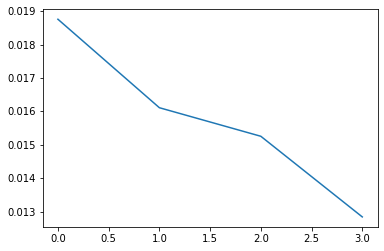

In [11]:
import matplotlib.pyplot as plt
plt.plot(r)

In [ ]:
rewards = 1-torch.ne(response, 1169).float()

In [ ]:
compute_rewards(scores, logprobs, ref_logprobs).shape

In [ ]:
logprobs.shape[0]